# Smile Classifier

Using CelebA dataset to train a smile classifier. Convolutional Neural Network (CNN) is used to classify the images. 

## Install the required libraries

In [1]:
!pip install torchvision==0.17.0 torch==2.2.0 matplotlib==3.7.4 numpy==1.24.4

## Explore the dataset

In [2]:
import torchvision

image_path = './'

celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split='train', target_type='attr', download=True)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split='valid', target_type='attr', download=True)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split='test', target_type='attr', download=True)


print(f'Train set: {len(celeba_train_dataset)}')
print(f'Validation set: {len(celeba_valid_dataset)}')
print(f'Test set: {len(celeba_test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train set: 162770
Validation set: 19867
Test set: 19962


## Image transformation and data augmentation

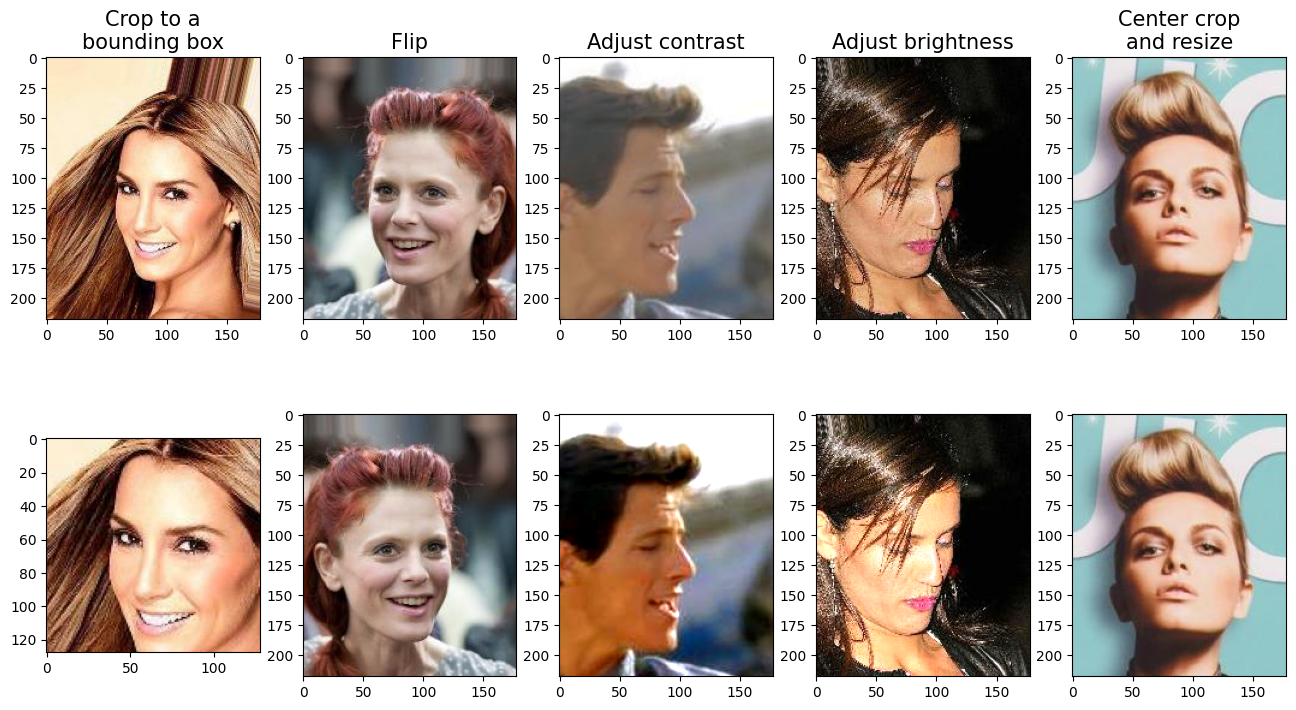

In [3]:
import matplotlib.pyplot as plt
from torchvision import transforms

fig = plt.figure(figsize=(16, 8.5))

# Column 1: cropping to a bounding box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a\nbounding box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

# Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

# Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust contrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

# Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr= celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

# Column 5: cropping from image center
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img, size=(218, 178))
ax.imshow(img_resized)

plt.show()

In [4]:
def get_smile(attr): return attr[18]


transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

In [5]:
from torch.utils.data import DataLoader, Subset
import torch

celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split='train', target_type='attr', download=False, transform=transform_train, target_transform=get_smile)

celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split='valid', target_type='attr', download=False, transform=transform, target_transform=get_smile)

celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split='test', target_type='attr', download=False, transform=transform, target_transform=get_smile)

In [6]:
batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

## Building and Training the model

In [7]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) # Global Average Pooling Layer

model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * batch_size
    accuracy_hist_train = [0] * batch_size
    loss_hist_valid = [0] * batch_size
    accuracy_hist_valid = [0] * batch_size

    for epoch in range(num_epochs):
        model.train()

        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [10]:
torch.manual_seed(1)
num_epochs = 25
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.6210 val_accuracy: 0.7160
Epoch 2 accuracy: 0.6998 val_accuracy: 0.7220
Epoch 3 accuracy: 0.7236 val_accuracy: 0.7420
Epoch 4 accuracy: 0.7336 val_accuracy: 0.7720
Epoch 5 accuracy: 0.7508 val_accuracy: 0.8070
Epoch 6 accuracy: 0.7629 val_accuracy: 0.7920
Epoch 7 accuracy: 0.7833 val_accuracy: 0.7800
Epoch 8 accuracy: 0.7974 val_accuracy: 0.7870
Epoch 9 accuracy: 0.8092 val_accuracy: 0.8200
Epoch 10 accuracy: 0.8159 val_accuracy: 0.8370
Epoch 11 accuracy: 0.8304 val_accuracy: 0.8510
Epoch 12 accuracy: 0.8364 val_accuracy: 0.8420
Epoch 13 accuracy: 0.8407 val_accuracy: 0.8550
Epoch 14 accuracy: 0.8428 val_accuracy: 0.8510
Epoch 15 accuracy: 0.8479 val_accuracy: 0.8610
Epoch 16 accuracy: 0.8518 val_accuracy: 0.8600
Epoch 17 accuracy: 0.8518 val_accuracy: 0.8820
Epoch 18 accuracy: 0.8586 val_accuracy: 0.8690
Epoch 19 accuracy: 0.8602 val_accuracy: 0.8720
Epoch 20 accuracy: 0.8592 val_accuracy: 0.8740
Epoch 21 accuracy: 0.8633 val_accuracy: 0.8720
Epoch 22 accuracy: 0.8

## Visualizing the results

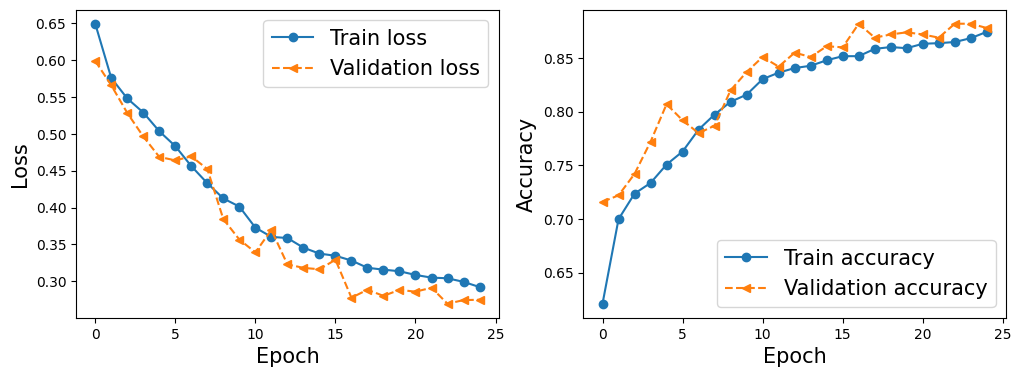

In [25]:
import numpy as np

x_arr = np.arange(25)
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0][:num_epochs], '-o', label='Train loss')
ax.plot(x_arr, hist[1][:num_epochs], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2][:num_epochs], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3][:num_epochs], '--<', label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

fig.savefig('loss_accuracy.png')

## Testing the model

In [28]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.8624


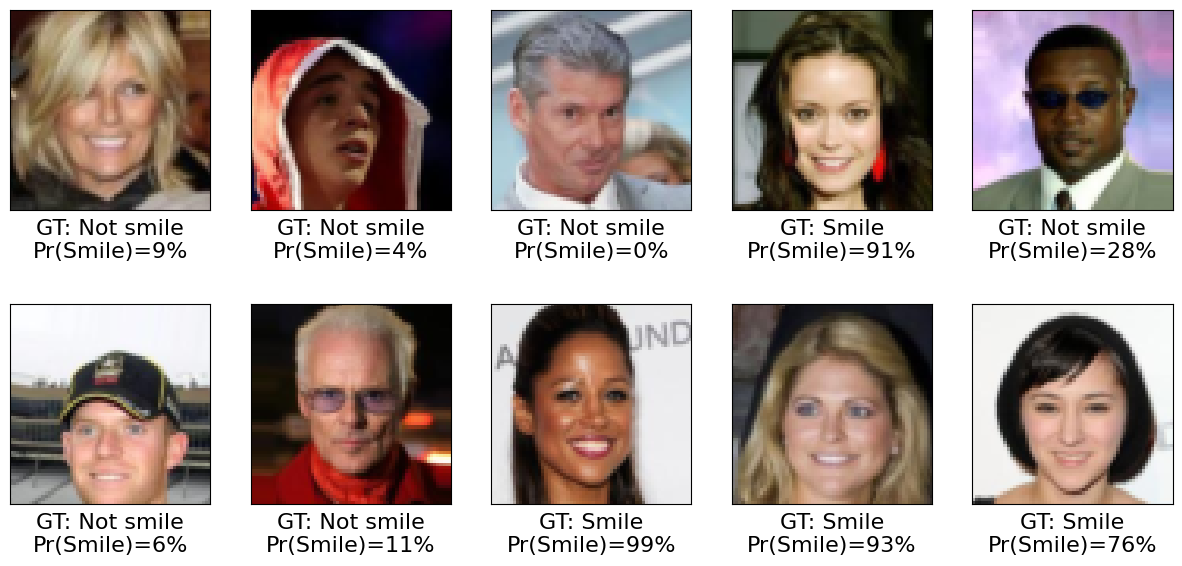

In [33]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))

    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not smile'

    ax.text(
        0.5, -0.15,
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )
plt.show()
fig.savefig('results.png')